
# Практика 4



## Выполнил студент группы ББМО-01-23 Егоров Юрий Александрович

### Пункт 1 Загрузка обученной модели и данных MNIST


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.9733 - loss: 0.0970
Test accuracy on clean images: 0.9768000245094299


### Пункт 2 Реализация атаки Deepfool


Меточка класса: 2


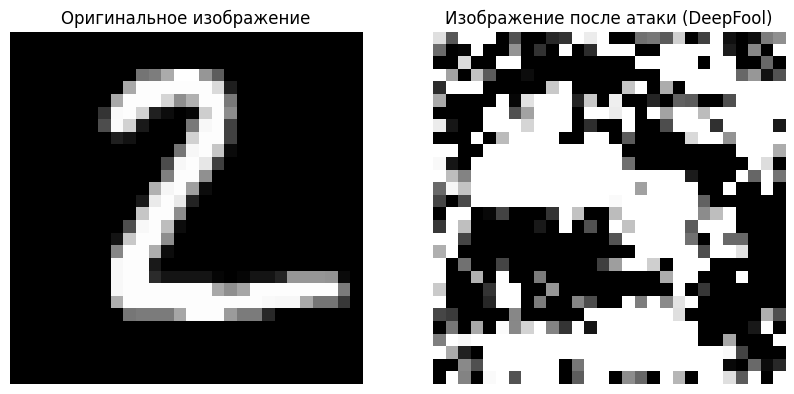

In [4]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация модели в Foolbox
# Указываем модель и пределы входных значений (-1, 1)
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Получение изображения и метки из тестового набора данных
# Преобразуем изображение в тензор и добавляем размерность для батча
image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]
label = tf.convert_to_tensor(np.argmax(test_labels[1]), dtype=tf.int64)

# Определяем и настраиваем атаку L2 DeepFool
# Указываем количество шагов для атаки
attack = fb.attacks.L2DeepFoolAttack(steps=15)  # Заменено на 15 шагов для демонстрации различия
print("Меточка класса:", label.numpy())

# Выполнение атаки с epsilon=0.01
# Оборачиваем метку в тензор с размерностью (1,)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Визуализация исходного и измененного изображений
plt.figure(figsize=(10, 5))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

# Измененное изображение после атаки
plt.subplot(1, 2, 2)
plt.title("Изображение после атаки (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

# Отображение графиков
plt.show()


### Пункт 3
 Оценка модели на противоречивых примерах

In [7]:
import tensorflow as tf
import numpy as np

# Список для хранения противоречивых изображений
adversarial_images = []

# Перебор каждого тестового изображения и создание противоречивого примера
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]  # Добавляем размерность батча
    label = np.argmax(test_labels[i])  # Получаем индекс метки как скаляр
    label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор
    
    # Выполнение атаки для создания противоречивого примера
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Добавляем размерность батча к метке
    adversarial_images.append(advs[0])  # Добавляем противоречивое изображение без лишней размерности батча

# Объединяем все противоречивые изображения вдоль оси батча
adversarial_images = tf.stack(adversarial_images, axis=0)  # Используем stack для одинаковой формы
test_labels_tensor = tf.convert_to_tensor([np.argmax(lbl) for lbl in test_labels], dtype=tf.int64)  # Целочисленные метки

# Преобразуем метки в формат one-hot для корректного ранга
num_classes = model.output_shape[-1]  # Определяем количество классов по выходной форме модели
test_labels_one_hot = tf.one_hot(test_labels_tensor, depth=num_classes)

# Оцениваем точность модели на противоречивых изображениях
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels_one_hot)
print(f'Точность на противоречивых примерах (DeepFool): {adversarial_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.0000e+00 - loss: 136.9725
Точность на противоречивых примерах (DeepFool): 0.0


### Вывод

Точность модели на атакованных применарх составила около %0, что говорит о том, что мождель не справляется с задачей распознавания в условиях небольших целеноправленных искажений.